<a href="https://colab.research.google.com/github/jjyjung/ai_mfg/blob/main/yolov11_milling_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI를 이용한 밀링헤드 모니터링 실습**💡

*   **목적** : 머신비전을 이용하여 밀링헤드의 파손부위를 검출하는 예제

*   **알고리즘** : 객체 검출(Object Detection) 알고리즘 YOLOv11 (출처: https://docs.ultralytics.com/ko/models/yolo11/)

*   **데이터셋** : Edge milling heads Dataset (출처: https://gvis.unileon.es/datasets-emh-144/)

 *해당 데이터셋은 현재 연구목적으로 전달받은 데이터로 배포 금지 요망*


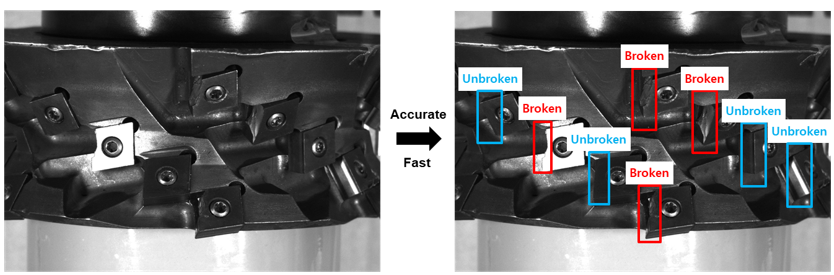



 ## **0. Colab 런타임 유형 변경 (CPU -> GPU)**
 * 딥러닝을 이용한 이미지 학습에는 CPU보다 GPU 연산이 속도가 빠름
 * Colab의 런타임 유형은 CPU가 기본으로 되어있어서 GPU로 변경하는 것이 좋음
 * 메뉴 > 런타임 > 런타임유형변경에서 GPU로 선택을 변경할 수 있음


 ## **1. 데이터 준비**

### **1.1. 데이터 소개**

* 6개의 밀링헤드에 대하여 각각 24장의 이미지를 촬영하여, 총 120장의 이미지를 저장하고 있음
* 가공 중 밀링헤드의 정지 시점에 약간씩 회전하면서 촬영한 정지영상을 사용하여 파손 여부를 진단함
* 하나의 밀링헤드에는 30개의 insert가 장착되어 있으며, 이 insert 중에서 사용 중에 파손된 insert를 탐지하는 것을 목표로 함
* 정상 insert는 'unbroken', 깨진 insert는 'broken'으로 라벨링


 ### **1.2. 데이터 라벨링**

*   이미지 학습을 위하여 데이터의 분류값을 지정하는 것을 데이터 라벨링(data labeling)이라고 하며, 이미지 데이터에 대해서도 사전에 수작업으로 이미지의 어떤 부분에 어떤 객체가 존재하는지 지정해야하며 이를 데이터 라벨링 또는 데이터 어노테이션(annotation)이라고 함
*   정상 insert는 'unbroken', 깨진 insert는 'broken'으로 라벨링
*   라벨링 완료 후, YOLO format으로 export

### **1.3. 파일 업로드**
 * 아래 코드를 실행시켜서 Google Drive에 연결을 승인하시오.

In [1]:
# 구글 드라이브 연결하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 * **milling.zip 파일을 Google Drive의 아래 폴더에 업로드한 후, 압축을 풀고 내용을 확인하시오.**
    * 파일 링크: https://drive.google.com/drive/folders/1Z1w7oLi80NpBk-CQPzOxMyNE186BXiOE
    * 폴더 예시: /content/gdrive/My Drive/Colab Notebooks/ai/milling

In [6]:
# 1. 파일 업로드
# Google Drive의 zip 파일 압축 풀기
%cd '/content/drive/MyDrive/Colab Notebooks/ai/milling/'
!unzip -qq milling.zip

/content/drive/MyDrive/Colab Notebooks/ai/milling


## **2. YOLOv11 코드 불러오기**

In [3]:
# 관련 라이브러리 설치하기
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.2/915.2 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
from ultralytics import YOLO

# 2. 모델 로드 (사전 학습된 모델)
model = YOLO("yolo11n.pt")  # 사전 학습된 YOLOv11 Nano 모델 로드

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 100MB/s]


## **3. 모델 학습**

### **3.1. 학습 설정 파일(.yaml) 만들기**

In [7]:
import os

# 3. 데이터셋 경로 설정
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/'
TRAIN_IMAGES = "images/train"
VALIDATION_IMAGES = "images/validation"
TEST_IMAGES = "images/test"

# 4. 데이터셋 명세 생성
# Ultralytics는 `data.yaml` 파일이 필요합니다.
# 데이터셋 구성 YAML 파일 생성. f는 변수를 받아와서 파일을 동적 생성하기 위한 옵션
DATA_YAML_CONTENT = f"""
# root dir
# path: /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/
path: {DATASET_PATH}

# data dir  (relative to 'path')
train: {TRAIN_IMAGES}
val: {VALIDATION_IMAGES}
test: {TEST_IMAGES}

# classes
nc: 2  # number of classes
names: ['unbroken', 'broken']  # class names
"""

# data.yaml 파일 저장
yaml_path = os.path.join(DATASET_PATH, "data.yaml")
# os.makedirs(os.path.dirname(yaml_path), exist_ok=True)  # data.yaml 저장 경로 확인 및 생성
with open(yaml_path, "w") as f:
    f.write(DATA_YAML_CONTENT)
print("data.yaml 생성 완료!")

data.yaml 생성 완료!


### **3.2. YOLO 모델의 Fine-Tuning**

In [8]:
# 4. Fine-Tuning 설정
model.train(
    data=yaml_path,             # 데이터셋 설정 파일 경로
    epochs=100,                  # 훈련할 에포크 수
    batch=16,                   # 배치 크기
    imgsz=640,                  # 입력 이미지 크기
    workers=4,                  # 데이터 로더의 워커 수
    device=0,                   # GPU 사용 (0: 첫 번째 GPU)  <- GPU를 사용하는 경우
    # device="cpu",             # CPU 사용 설정            <- CPU를 사용하는 경우
    project="YOLOv11_FineTune", # 결과를 저장할 프로젝트 이름
    name="millinghead"          # 실험 이름
)

Ultralytics 8.3.76 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=YOLOv11_FineTune, name=millinghead2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/labels/train... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 142.69it/s]


train: New cache created: /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/labels/validation... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 87.66it/s]

val: New cache created: /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/labels/validation.cache


Plotting labels to YOLOv11_FineTune/millinghead2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to YOLOv11_FineTune/millinghead2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.47G      3.218      4.266      2.386         34        640: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         20        170          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.32G      2.547      3.983      1.829         60        640: 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         20        170     0.0187      0.854     0.0173    0.00696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.34G      1.753      3.151      1.216         63        640: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

                   all         20        170     0.0239      0.814     0.0792     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.27G      1.571      2.584      1.059         47        640: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         20        170     0.0257      0.805      0.362      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.31G      1.487      2.057      1.026         46        640: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         20        170     0.0257      0.949      0.355      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.33G      1.422      1.561      1.031         36        640: 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         20        170      0.882      0.337      0.433      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.32G      1.377      1.378      1.012         37        640: 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         20        170     0.0314      0.952       0.48      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.33G      1.387      1.289      1.031         48        640: 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         20        170      0.941      0.426      0.525      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.31G      1.326      1.257      1.009         45        640: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         20        170      0.964      0.448      0.529      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.33G      1.255      1.165     0.9937         75        640: 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         20        170      0.959      0.499       0.54      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.29G      1.263       1.11      0.984         63        640: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         20        170       0.96      0.475      0.518      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.28G      1.244       1.07     0.9718         63        640: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         20        170      0.965      0.499      0.506      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.28G      1.185      1.068     0.9728         62        640: 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         20        170      0.947        0.5      0.505      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.32G      1.187      1.072     0.9831         33        640: 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         20        170      0.949        0.5      0.508      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.29G      1.214      1.059     0.9751         65        640: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         20        170      0.947        0.5        0.5      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.31G      1.203      1.028     0.9711         66        640: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         20        170      0.956        0.5      0.501      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.29G       1.24     0.9971     0.9684         55        640: 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         20        170      0.952        0.5      0.505       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.33G      1.205      1.076      0.985         26        640: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         20        170      0.955        0.5      0.513      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.27G      1.151     0.9726     0.9577         77        640: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         20        170      0.939      0.497      0.519      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.35G      1.136     0.9698     0.9515         50        640: 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         20        170      0.506      0.542      0.545      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.37G       1.14     0.9298     0.9442         47        640: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         20        170      0.513      0.625      0.558      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.28G      1.147     0.9539     0.9642         35        640: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         20        170      0.518       0.75      0.603      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.35G      1.138     0.9389     0.9631         34        640: 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         20        170      0.512      0.625      0.599      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.28G      1.137     0.9367     0.9428         68        640: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         20        170      0.498      0.686      0.559      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.28G      1.092     0.9127     0.9473         40        640: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         20        170      0.507      0.708      0.591      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.32G      1.098     0.9307     0.9397         72        640: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         20        170      0.553      0.708      0.604       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.35G      1.116        0.9     0.9343         72        640: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         20        170      0.957        0.5       0.53       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.33G      1.122     0.9581     0.9428         39        640: 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         20        170      0.543      0.569       0.59      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.33G      1.086     0.9125     0.9285         50        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         20        170      0.584      0.619      0.611      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.28G      1.088     0.8752     0.9312         67        640: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         20        170      0.594      0.705      0.641      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.31G      1.123     0.8785     0.9429         86        640: 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         20        170      0.683      0.667      0.638      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.33G      1.083      0.854     0.9343         43        640: 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         20        170      0.688      0.625      0.647      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.36G      1.031     0.8735     0.9091         94        640: 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         20        170      0.657      0.667      0.679      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.28G      1.026     0.8377       0.91         69        640: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         20        170      0.723      0.706      0.716      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.27G      1.056     0.8477     0.9267         58        640: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         20        170      0.678      0.654      0.701      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.31G      1.077     0.8486     0.9198         79        640: 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         20        170      0.927      0.658      0.696      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.33G      1.044     0.8321     0.9252         64        640: 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         20        170      0.848      0.667      0.738      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.35G      1.044     0.8317      0.908         57        640: 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         20        170      0.735      0.785      0.717      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.3G      1.055     0.8233     0.9181         71        640: 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         20        170       0.92      0.616      0.731      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.3G      1.101     0.8282     0.9398         60        640: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         20        170      0.843      0.583      0.693      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.27G      1.042     0.7942     0.9302         40        640: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         20        170      0.907      0.608      0.704      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.32G      1.033     0.8018     0.9038         67        640: 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         20        170      0.774      0.747      0.765      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.32G      1.035     0.7959     0.9138         64        640: 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         20        170      0.954      0.744      0.786      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.33G      1.033     0.7803     0.9167         41        640: 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         20        170      0.843      0.708      0.762      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.29G      1.031     0.7605      0.911         45        640: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         20        170      0.827      0.672      0.756      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.35G      0.992     0.7533     0.9075         47        640: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         20        170      0.864       0.74      0.783      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.32G      1.013     0.7542     0.9229         47        640: 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         20        170      0.741      0.789      0.766      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.33G      1.043     0.7579     0.9162         36        640: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         20        170      0.758      0.731      0.742      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.29G      1.026     0.7599     0.9136         36        640: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         20        170      0.695      0.827      0.758       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.28G      0.997     0.7322     0.9066         64        640: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         20        170      0.852      0.738      0.759      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.31G      1.028     0.8121     0.9246         42        640: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         20        170      0.862       0.75      0.766      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.35G       1.02     0.7717     0.9301         43        640: 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         20        170      0.709      0.778      0.734      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.36G     0.9942     0.7155     0.9183         57        640: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         20        170      0.691       0.75      0.717      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.27G     0.9962     0.7225     0.9202         39        640: 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         20        170      0.882      0.747      0.788      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.25G      1.009     0.7309     0.9136         45        640: 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         20        170      0.848      0.733      0.785      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.29G      1.015     0.7436     0.9001         87        640: 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         20        170      0.748      0.792       0.78      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.3G      1.009     0.7463     0.9175         60        640: 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         20        170      0.711      0.792       0.78      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.33G      1.007     0.7399     0.9169         32        640: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         20        170      0.799      0.708      0.752      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.32G      1.017     0.7361     0.9073         62        640: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         20        170      0.791      0.667      0.713      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.33G     0.9701     0.7029     0.9129         53        640: 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         20        170      0.967      0.661      0.728        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.28G      1.014     0.7347     0.9134         50        640: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         20        170      0.858      0.664      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.28G      1.011     0.7336     0.9103         63        640: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         20        170      0.724       0.75      0.777      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.27G     0.9521     0.7107     0.9069         35        640: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         20        170      0.946      0.692      0.797      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.26G     0.9739     0.7162     0.9158         42        640: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         20        170      0.952      0.689      0.779      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.33G     0.9764     0.7201     0.8975         84        640: 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         20        170      0.831       0.74      0.783      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.35G      1.014     0.7132     0.9186         29        640: 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         20        170      0.732      0.792      0.785      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.31G     0.9508     0.6985      0.911         48        640: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         20        170       0.76      0.792      0.778      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.33G          1     0.7112     0.9026         75        640: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         20        170      0.882      0.739      0.801      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.28G     0.9659     0.6995     0.9006         57        640: 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         20        170      0.808       0.75      0.794      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.33G     0.9825     0.6768     0.9064         61        640: 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         20        170      0.867      0.747      0.795      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.38G     0.9723     0.6645     0.9005         51        640: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         20        170      0.864       0.75      0.804      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.33G     0.9498     0.6781     0.9015         29        640: 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         20        170      0.876       0.75      0.814      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.28G     0.9452     0.6643     0.8977         61        640: 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         20        170      0.877      0.782      0.816      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.28G     0.9591     0.6646     0.8963         73        640: 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         20        170       0.89      0.782      0.819      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.27G      0.947     0.6661     0.9104         27        640: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         20        170      0.819       0.82      0.822      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.33G     0.9635      0.658     0.8926         83        640: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         20        170      0.857       0.83      0.829      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.29G     0.9264     0.6704     0.9005         54        640: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         20        170      0.872      0.821      0.835      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.33G     0.9551     0.6716      0.894         47        640: 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         20        170      0.834      0.765      0.846      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.28G     0.9286     0.6411     0.8948         40        640: 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         20        170      0.872      0.704      0.824       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.33G     0.9278     0.6504     0.8969         79        640: 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         20        170      0.853      0.705      0.791      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.28G     0.9255     0.6593     0.8949         42        640: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         20        170      0.863      0.705      0.798      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.28G     0.9313     0.6543     0.8916         61        640: 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         20        170      0.779      0.833      0.844      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.33G     0.9371     0.6366     0.8913         45        640: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         20        170      0.835      0.782      0.839      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.28G     0.9227     0.6579     0.8949         40        640: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         20        170      0.866      0.695      0.812      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.31G     0.9149     0.6487     0.8822         63        640: 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

                   all         20        170      0.873      0.699      0.789       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.34G      0.935     0.6441      0.892         89        640: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         20        170      0.881      0.702      0.772      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.27G     0.9101     0.6245     0.8828         51        640: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         20        170      0.874      0.702      0.781      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.32G     0.8912     0.6358     0.8949         40        640: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         20        170      0.864      0.699      0.789      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.29G     0.9179     0.6332     0.8965         44        640: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         20        170      0.869      0.696      0.801      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.29G      0.934     0.6362     0.8825         81        640: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         20        170      0.768      0.863      0.838        0.6


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.28G     0.8863     0.6858     0.8847         34        640: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         20        170      0.774      0.871      0.853        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.26G     0.9043     0.6763     0.8955         30        640: 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         20        170      0.806      0.781      0.836      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.25G     0.8936     0.6616     0.8782         30        640: 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         20        170      0.698      0.882      0.834      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.26G     0.8806     0.6442     0.8822         31        640: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         20        170      0.848      0.735      0.826      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.25G     0.8711     0.6455     0.8744         28        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         20        170      0.837      0.737      0.825      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.26G     0.8721     0.6199      0.878         31        640: 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         20        170      0.828      0.741      0.809      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.26G     0.8814     0.6278     0.8791         32        640: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         20        170      0.825      0.741      0.813      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.26G     0.8803     0.6325     0.8832         31        640: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


                   all         20        170      0.901      0.735      0.816      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.25G     0.8624     0.6152     0.8713         36        640: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         20        170      0.895      0.741      0.819      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.25G     0.8833     0.6179     0.8795         32        640: 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         20        170      0.896      0.741      0.818      0.569



100 epochs completed in 0.086 hours.
Optimizer stripped from YOLOv11_FineTune/millinghead2/weights/last.pt, 5.5MB
Optimizer stripped from YOLOv11_FineTune/millinghead2/weights/best.pt, 5.5MB

Validating YOLOv11_FineTune/millinghead2/weights/best.pt...
Ultralytics 8.3.76 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         20        170      0.773      0.871      0.853      0.604
              unbroken         20        158      0.929      0.992      0.972      0.722
                broken          8         12      0.618       0.75      0.734      0.486
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to YOLOv11_FineTune/millinghead2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a203313bbd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## **4. 성능 평가**

### **4.1. Test 성능 평가**

In [10]:
# 경로 설정
MODEL_PATH =      '/content/drive/MyDrive/Colab Notebooks/ai/milling/YOLOv11_FineTune/millinghead2/weights/best.pt'           # 프로젝트로 새롭게 생성된 예측 모형 파일
MODEL_COPY_PATH = '/content/drive/MyDrive/Colab Notebooks/ai/milling/best_100.pt'   # 복사할 모형 파일명
YAML_PATH =       '/content/drive/MyDrive/Colab Notebooks/ai/milling/data.yaml'     # 데이터셋 구성 파일 경로
TEST_IMAGES_DIR = '/content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/images/test'  # 테스트 이미지 경로
SAVE_DIR =        '/content/drive/MyDrive/Colab Notebooks/ai/milling/test_results'  # 결과 저장 경로

# !cp {source_path} {destination_path}

import shutil
shutil.copy(MODEL_PATH, MODEL_COPY_PATH)
print(f"File copied to {MODEL_COPY_PATH}")

File copied to /content/drive/MyDrive/Colab Notebooks/ai/milling/best_100.pt


In [11]:
# 5. Test Set 성능 평가
def evaluate_test_set(model, yaml_path):
    # 테스트 성능 평가
    results = model.val(data=yaml_path, split="test", save_json=True)

    # 디버깅: 반환된 객체 구조 확인
    # print(dir(results))  # 객체의 속성 확인
    # print(results.results_dict)  # results_dict 내용 확인
    print(f"Precision: {results.results_dict['metrics/precision(B)']:.4f}")
    print(f"Recall: {results.results_dict['metrics/recall(B)']:.4f}")
    print(f"mAP@50: {results.results_dict['metrics/mAP50(B)']:.4f}")
    print(f"mAP@50-95: {results.results_dict['metrics/mAP50-95(B)']:.4f}")

    # 결과 저장 디렉토리 확인
    print("\n결과가 저장된 경로:")
    print(results.save_dir)

# 6. 학습된 모델 로드 및 테스트 실행
TEST_IMAGE_PATH = os.path.join(DATASET_PATH, "images/test")
# TEST_IMAGE_PATH = DATASET_PATH + "images/test"

if os.path.exists(MODEL_PATH):
    print("\n학습된 모델 로드 중...")
    model = YOLO(MODEL_PATH)
    evaluate_test_set(model, yaml_path)
else:
    print("\n학습된 모델이 존재하지 않습니다. 학습을 완료한 후 실행하세요.")


학습된 모델 로드 중...
Ultralytics 8.3.76 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/labels/test... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 133.69it/s]


val: New cache created: /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


                   all         24        206      0.849      0.792       0.86      0.554
              unbroken         24        154      0.834      0.949      0.916      0.659
                broken         21         52      0.864      0.635      0.804       0.45
Speed: 5.8ms preprocess, 30.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val
Precision: 0.8493
Recall: 0.7920
mAP@50: 0.8600
mAP@50-95: 0.5543

결과가 저장된 경로:
runs/detect/val


In [12]:
import os
from ultralytics import YOLO
from PIL import Image

def detect_and_save_results(model_path, yaml_path, test_images_dir, save_dir):
    """
    학습된 모델로 Test Set을 평가하고 Detection 결과를 저장하는 함수.

    Args:
        model_path (str): 학습된 YOLO 모델 경로.
        yaml_path (str): 데이터셋 구성 파일(data.yaml)의 경로.
        test_images_dir (str): 테스트 이미지가 있는 디렉토리 경로.
        save_dir (str): Detection 결과를 저장할 디렉토리 경로.
    """
    # 모델 로드
    model = YOLO(model_path)

    # 저장 디렉토리 생성
    os.makedirs(save_dir, exist_ok=True)

    # Test Set의 모든 이미지 파일 탐색
    test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('jpg', 'png', 'bmp'))]

    if not test_images:
        print("테스트 이미지가 존재하지 않습니다.")
        return

    print(f"{len(test_images)}개의 테스트 이미지를 처리합니다...")

    # 각 이미지에 대해 Detection 수행 및 결과 저장
    for image_name in test_images:
        image_path = os.path.join(test_images_dir, image_name)

        # Detection 수행
        results = model(image_path, save=False)  # save=False로 설정하여 자동 저장 방지

        # 시각화된 결과 이미지 가져오기
        result_image = results[0].plot()  # 첫 번째 이미지의 결과 시각화

        # 저장 경로 설정
        output_path = os.path.join(save_dir, image_name)

        # 결과 이미지를 저장
        result_image_pil = Image.fromarray(result_image)  # numpy array -> PIL 이미지 변환
        result_image_pil.save(output_path)
        print(f"결과 저장: {output_path}")

    print("\n모든 Detection 결과가 저장되었습니다!")

# 함수 실행
detect_and_save_results(MODEL_PATH, YAML_PATH, TEST_IMAGES_DIR, SAVE_DIR)

24개의 테스트 이미지를 처리합니다...

image 1/1 /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/images/test/HeadTool0121.bmp: 480x640 9 unbrokens, 2 brokens, 44.7ms
Speed: 3.2ms preprocess, 44.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
결과 저장: /content/drive/MyDrive/Colab Notebooks/ai/milling/test_results/HeadTool0121.bmp

image 1/1 /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/images/test/HeadTool0122.bmp: 480x640 11 unbrokens, 2 brokens, 10.4ms
Speed: 2.1ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
결과 저장: /content/drive/MyDrive/Colab Notebooks/ai/milling/test_results/HeadTool0122.bmp

image 1/1 /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/images/test/HeadTool0123.bmp: 480x640 9 unbrokens, 3 brokens, 12.4ms
Speed: 2.5ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
결과 저장: /content/drive/MyDrive/Colab Notebooks/ai/milling/test_results/HeadTool0123.bmp

image 